# Singular Spectorum Analysis


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# plot utils for singular_spectorum

def plot_spectra(spectra, title=None, ax=None, **kwargs):
    """Plot the spectra of the singular values of a matrix.
    
    Parameters
    ----------
    spectra : array-like
        The singular values of a matrix.
    title : str, optional
        The title of the plot.
    ax : matplotlib.axes.Axes, optional
        The axes to plot on.
    kwargs : dict, optional
        Keyword arguments to pass to `ax.plot`.
    """
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(spectra, **kwargs)
    ax.set_xlabel('Singular value index')
    ax.set_ylabel('Singular value')
    if title is not None:
        ax.set_title(title)
    return ax

def plot_spectra_hist(spectra, title=None, ax=None, **kwargs):
    """Plot the histogram of the spectra of the singular values of a matrix.
    
    Parameters
    ----------
    spectra : array-like
        The singular values of a matrix.
    title : str, optional
        The title of the plot.
    ax : matplotlib.axes.Axes, optional
        The axes to plot on.
    kwargs : dict, optional
        Keyword arguments to pass to `ax.hist`.
    """
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(spectra, **kwargs)
    ax.set_xlabel('Singular value')
    ax.set_ylabel('Frequency')
    if title is not None:
        ax.set_title(title)
    return ax

def plot_2d_matrix(matrix, title=None, ax=None, **kwargs):
    """Plot a 2D matrix.
    
    Parameters
    ----------
    matrix : array-like
        The matrix to plot.
    title : str, optional
        The title of the plot.
    ax : matplotlib.axes.Axes, optional
        The axes to plot on.
    kwargs : dict, optional
        Keyword arguments to pass to `ax.imshow`.
    """
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(matrix, **kwargs)
    ax.set_xlabel('Column index')
    ax.set_ylabel('Row index')
    if title is not None:
        ax.set_title(title)
    return ax



In [3]:
# Toy time series data for singular_spectorum 
No = 300 # The number of time 'moments' in our toy series
N = 200 # The number of time 'moments' we will use for training
t = np.arange(0,No)
trend = 0.001 * (t - 100)**2
p1, p2 = 20, 30
periodic1 = 2 * np.sin(2*np.pi*t/p1)
periodic2 = 0.75 * np.sin(2*np.pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(No) - 0.5)
Fo = trend + periodic1 + periodic2 + noise

Ftest = Fo[N:]
F = Fo[:N]


Text(0.5, 1.0, 'Toy time series')

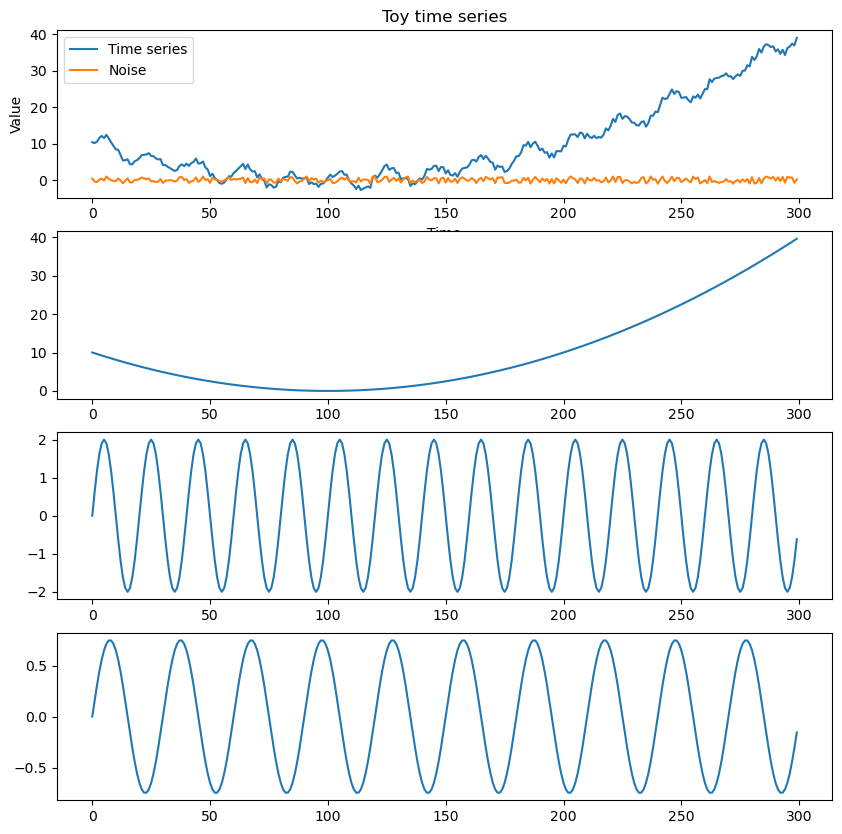

In [4]:
# plot the time series and its components
fig, ax = plt.subplots(4,1, figsize=(10,10))
ax[0].plot(t, Fo, label='Time series')
ax[1].plot(t, trend, label='Trend')
ax[2].plot(t, periodic1, label='Periodic 1')
ax[3].plot(t, periodic2, label='Periodic 2')
ax[0].plot(t, noise, label='Noise')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_title('Toy time series')


# SSA 
## Step 1: From time series to trajectory matrix
The first step of the SSA is to convert the time series into a trajectory matrix. The trajectory matrix is a matrix of size $L \times m$ where $L$ is the number of time points and $K = N-L+1$ is the number of time series. The trajectory matrix is constructed by stacking the time series on top of each other. The trajectory matrix is denoted by $X$.



Text(0.5, 1.0, 'Trajectory Matrix')

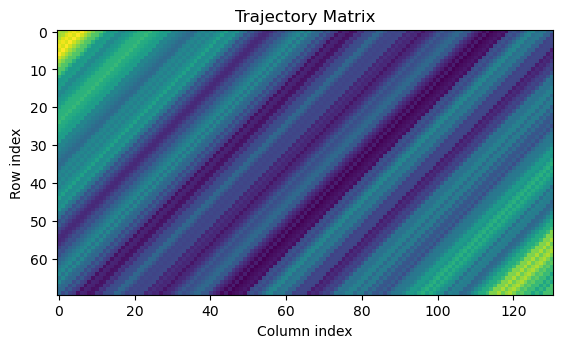

In [5]:
# Build the Trajectory Matrix
L=70 # The length of the trajectory
K = N - L + 1 # The number of trajectories
X = np.zeros((L, K))
for i in range(K):
    X[:,i] = F[i:i+L]

def build_trajectory_matrix(F, L):
    """Build the trajectory matrix from a time series.
    
    Parameters
    ----------
    F : array-like
        The time series.
    L : int
        The length of the trajectories.
        
    Returns
    -------
    X : array-like
        The trajectory matrix.
    """
    N = len(F)
    K = N - L + 1
    X = np.zeros((L, K))
    for i in range(K):
        X[:,i] = F[i:i+L]
    return X

# plot the trajectory matrix
fig, ax = plt.subplots()
plot_2d_matrix(X, ax=ax, cmap='viridis')
ax.set_title('Trajectory Matrix')



In [6]:
# Get the rank of the trajectory matrix
trm_rank = np.linalg.matrix_rank(X)

# Singular value decomposition
U, Sigma, V = np.linalg.svd(X, full_matrices=True)
V = V.T


In [7]:
# calculate the elementary matrices of the X matrix
x_e_matrices = np.zeros((trm_rank, L, K))
for i in range(trm_rank):
    x_e_matrices[i] = Sigma[i] * np.outer(U[:,i], V[:,i])

# check that the elementary matrices sum to the trajectory matrix
assert np.allclose(X, np.sum(x_e_matrices, axis=0))

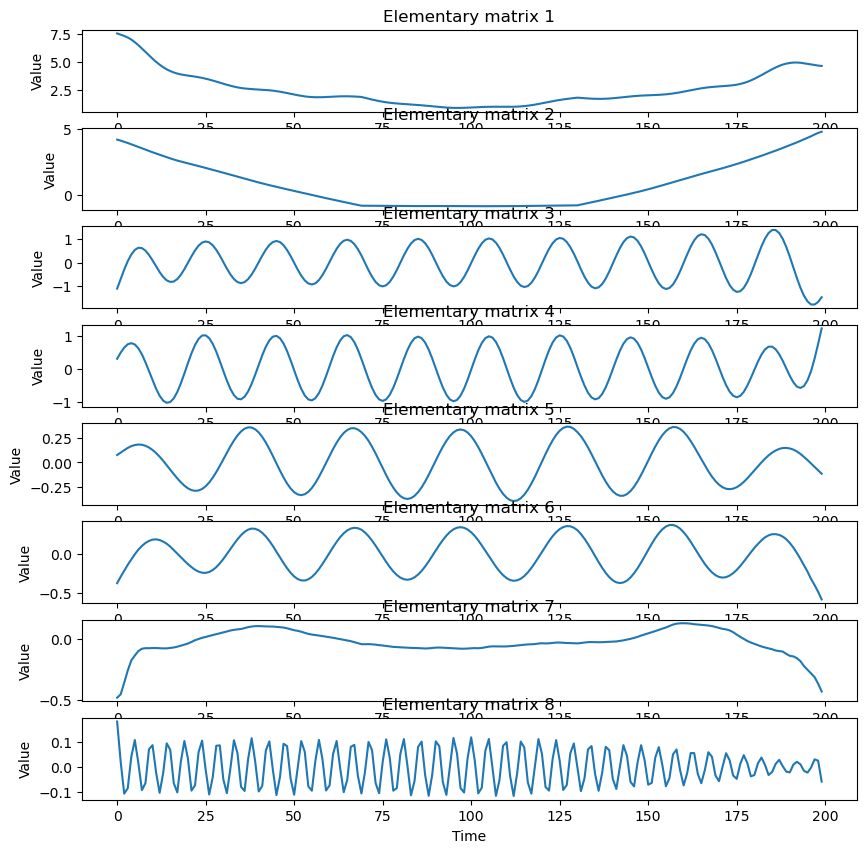

In [8]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

# plot the elementary matrices
fig, ax = plt.subplots(8, 1, figsize=(10, 10))
for i in range(8):
    ax[i].plot(t[:200], X_to_TS(x_e_matrices[i]))
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Value')
    ax[i].set_title('Elementary matrix {}'.format(i+1))

In [1]:
import numpy as np
import pandas as pd
from numpy import matrix as m
from pandas import DataFrame as df
from scipy import linalg
import seaborn
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4



In [12]:
class mySSA(object):
    '''Singular Spectrum Analysis object'''
    def __init__(self, time_series):
        
        self.ts = pd.DataFrame(time_series)
        self.ts_name = self.ts.columns.tolist()[0]
        if self.ts_name==0:
            self.ts_name = 'ts'
        self.ts_v = self.ts.values
        self.ts_N = self.ts.shape[0]
        self.freq = None 
    
    @staticmethod
    def _printer(name, *args):
        '''Helper function to print messages neatly'''
        print('-'*40)
        print(name+':')
        for msg in args:
            print(msg)  
    
    @staticmethod
    def _dot(x,y):
        '''Alternative formulation of dot product to allow missing values in arrays/matrices'''
        pass
    
    @staticmethod
    def get_contributions(X=None, s=None, plot=True):
        '''Calculate the relative contribution of each of the singular values'''
        lambdas = np.power(s,2)
        frob_norm = np.linalg.norm(X)
        ret = df(lambdas/(frob_norm**2), columns=['Contribution'])
        ret['Contribution'] = ret.Contribution.round(4)
        if plot:
            ax = ret[ret.Contribution!=0].plot.bar(legend=False)
            ax.set_xlabel("Lambda_i")
            ax.set_title('Non-zero contributions of Lambda_i')
            vals = ax.get_yticks()
            ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
            return ax
        return ret[ret.Contribution>0]
    
    @staticmethod
    def diagonal_averaging(hankel_matrix):
        '''Performs anti-diagonal averaging from given hankel matrix
        Returns: Pandas DataFrame object containing the reconstructed series'''
        mat = m(hankel_matrix)
        L, K = mat.shape
        L_star, K_star = min(L,K), max(L,K)
        new = np.zeros((L,K))
        if L > K:
            mat = mat.T
        ret = []
        
        #Diagonal Averaging
        for k in range(1-K_star, L_star):
            mask = np.eye(K_star, k=k, dtype='bool')[::-1][:L_star,:]
            mask_n = sum(sum(mask))
            ma = np.ma.masked_array(mat.A, mask=1-mask)
            ret+=[ma.sum()/mask_n]
        
        return df(ret).rename(columns={0:'Reconstruction'})
        
    def view_time_series(self):
        '''Plot the time series'''
        self.ts.plot(title='Original Time Series')
        
    def embed(self, embedding_dimension=None, suspected_frequency=None, verbose=False, return_df=False):
        '''Embed the time series with embedding_dimension window size.
        Optional: suspected_frequency changes embedding_dimension such that it is divisible by suspected frequency'''
        if not embedding_dimension:
            self.embedding_dimension = self.ts_N//2
        else:
            self.embedding_dimension = embedding_dimension
        if suspected_frequency:
            self.suspected_frequency = suspected_frequency
            self.embedding_dimension = (self.embedding_dimension//self.suspected_frequency)*self.suspected_frequency
    
        self.K = self.ts_N-self.embedding_dimension+1
        self.X = m(linalg.hankel(self.ts, np.zeros(self.embedding_dimension))).T[:,:self.K]
        self.X_df = df(self.X)
        self.X_complete = self.X_df.dropna(axis=1)
        self.X_com = m(self.X_complete.values)
        self.X_missing = self.X_df.drop(self.X_complete.columns, axis=1)
        self.X_miss = m(self.X_missing.values)
        self.trajectory_dimentions = self.X_df.shape
        self.complete_dimensions = self.X_complete.shape
        self.missing_dimensions = self.X_missing.shape
        self.no_missing = self.missing_dimensions[1]==0
            
        if verbose:
            msg1 = 'Embedding dimension\t:  {}\nTrajectory dimensions\t: {}'
            msg2 = 'Complete dimension\t: {}\nMissing dimension     \t: {}'
            msg1 = msg1.format(self.embedding_dimension, self.trajectory_dimentions)
            msg2 = msg2.format(self.complete_dimensions, self.missing_dimensions)
            self._printer('EMBEDDING SUMMARY', msg1, msg2)
        
        if return_df:
            return self.X_df
        
    def decompose(self, verbose=False):
        '''Perform the Singular Value Decomposition and identify the rank of the embedding subspace
        Characteristic of projection: the proportion of variance captured in the subspace'''
        X = self.X_com
        self.S = X*X.T
        self.U, self.s, self.V = linalg.svd(self.S)
        self.U, self.s, self.V = m(self.U), np.sqrt(self.s), m(self.V)
        self.d = np.linalg.matrix_rank(X)
        Vs, Xs, Ys, Zs = {}, {}, {}, {}
        for i in range(self.d):
            Zs[i] = self.s[i]*self.V[:,i]
            Vs[i] = X.T*(self.U[:,i]/self.s[i])
            Ys[i] = self.s[i]*self.U[:,i]
            Xs[i] = Ys[i]*(m(Vs[i]).T)
        self.Vs, self.Xs = Vs, Xs
        self.s_contributions = self.get_contributions(X, self.s, False)
        self.r = len(self.s_contributions[self.s_contributions>0])
        self.r_characteristic = round((self.s[:self.r]**2).sum()/(self.s**2).sum(),4)
        self.orthonormal_base = {i:self.U[:,i] for i in range(self.r)}
        
        if verbose:
            msg1 = 'Rank of trajectory\t\t: {}\nDimension of projection space\t: {}'
            msg1 = msg1.format(self.d, self.r)
            msg2 = 'Characteristic of projection\t: {}'.format(self.r_characteristic)
            self._printer('DECOMPOSITION SUMMARY', msg1, msg2)
    
    def view_s_contributions(self, adjust_scale=False, cumulative=False, return_df=False):
        '''View the contribution to variance of each singular value and its corresponding signal'''
        contribs = self.s_contributions.copy()
        contribs = contribs[contribs.Contribution!=0]
        if cumulative:
            contribs['Contribution'] = contribs.Contribution.cumsum()
        if adjust_scale:
            contribs = (1/contribs).max()*1.1-(1/contribs)
        ax = contribs.plot.bar(legend=False)
        ax.set_xlabel("Singular_i")
        ax.set_title('Non-zero{} contribution of Singular_i {}'.\
                     format(' cumulative' if cumulative else '', '(scaled)' if adjust_scale else ''))
        if adjust_scale:
            ax.axes.get_yaxis().set_visible(False)
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
        if return_df:
            return contribs
    
    @classmethod
    def view_reconstruction(cls, *hankel, names=None, return_df=False, plot=True, symmetric_plots=False):
        '''Visualise the reconstruction of the hankel matrix/matrices passed to *hankel'''
        hankel_mat = None
        for han in hankel:
            if isinstance(hankel_mat,m):
                hankel_mat = hankel_mat + han
            else: 
                hankel_mat = han.copy()
        hankel_full = cls.diagonal_averaging(hankel_mat)
        title = 'Reconstruction of signal'
        if names or names==0: 
            title += ' associated with singular value{}: {}'
            title = title.format('' if len(str(names))==1 else 's', names)
        if plot:
            ax = hankel_full.plot(legend=False, title=title)
            if symmetric_plots:
                velocity = hankel_full.abs().max()[0]
                ax.set_ylim(bottom=-velocity, top=velocity)
        if return_df:
            return hankel_full
    
    def _forecast_prep(self, singular_values=None):
        self.X_com_hat = np.zeros(self.complete_dimensions)
        self.verticality_coefficient = 0
        self.forecast_orthonormal_base = {}
        if singular_values:
            try:
                for i in singular_values:
                    self.forecast_orthonormal_base[i] = self.orthonormal_base[i]
            except:
                if singular_values==0:
                    self.forecast_orthonormal_base[0] = self.orthonormal_base[0]
                else:
                    raise('Please pass in a list/array of singular value indices to use for forecast')
        else:
            self.forecast_orthonormal_base = self.orthonormal_base
        self.R = np.zeros(self.forecast_orthonormal_base[0].shape)[:-1]
        for Pi in self.forecast_orthonormal_base.values():
            self.X_com_hat += Pi*Pi.T*self.X_com
            pi = np.ravel(Pi)[-1]
            self.verticality_coefficient += pi**2
            self.R += pi*Pi[:-1]
        self.R = m(self.R/(1-self.verticality_coefficient))
        self.X_com_tilde = self.diagonal_averaging(self.X_com_hat)
        
    def forecast_recurrent(self, steps_ahead=12, singular_values=None, plot=False, return_df=False, **plotargs):
        '''Forecast from last point of original time series up to steps_ahead using recurrent methodology
        This method also fills any missing data from the original time series.'''
        try:
            self.X_com_hat
        except(AttributeError):
            self._forecast_prep(singular_values)
        self.ts_forecast = np.array(self.ts_v[0])
        for i in range(1, self.ts_N+steps_ahead):
            try:
                if np.isnan(self.ts_v[i]):
                    x = self.R.T*m(self.ts_forecast[max(0,i-self.R.shape[0]): i]).T
                    self.ts_forecast = np.append(self.ts_forecast,x[0])
                else:
                    self.ts_forecast = np.append(self.ts_forecast,self.ts_v[i])
            except(IndexError):
                x = self.R.T*m(self.ts_forecast[i-self.R.shape[0]: i]).T
                self.ts_forecast = np.append(self.ts_forecast, x[0])
        self.forecast_N = i+1
        new_index = pd.date_range(start=self.ts.index.min(),periods=self.forecast_N, freq=self.freq)
        forecast_df = df(self.ts_forecast, columns=['Forecast'], index=new_index)
        forecast_df['Original'] = np.append(self.ts_v, [np.nan]*steps_ahead)
        if plot:
            forecast_df.plot(title='Forecasted vs. original time series', **plotargs)
        if return_df:
            return forecast_df
            


----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  70
Trajectory dimensions	: (70, 131)
Complete dimension	: (70, 131)
Missing dimension     	: (70, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 70
Dimension of projection space	: 66
Characteristic of projection	: 0.9998


/var/folders/t2/_nykd9tn43dfx142nv5r8l900000gn/T/ipykernel_18153/1879854657.py:141: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


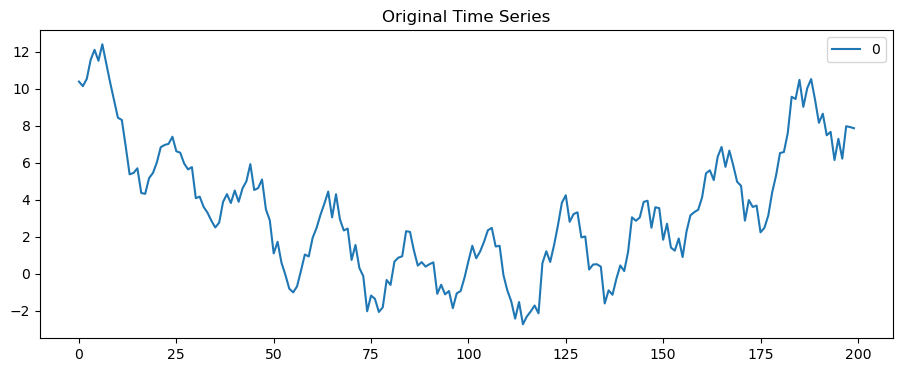

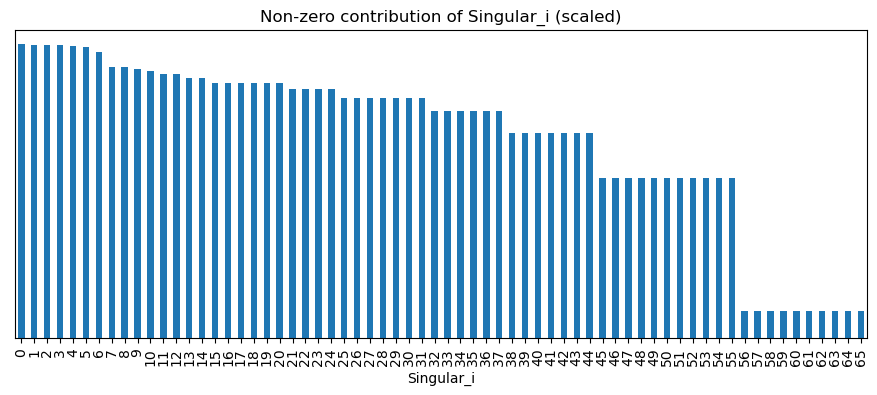

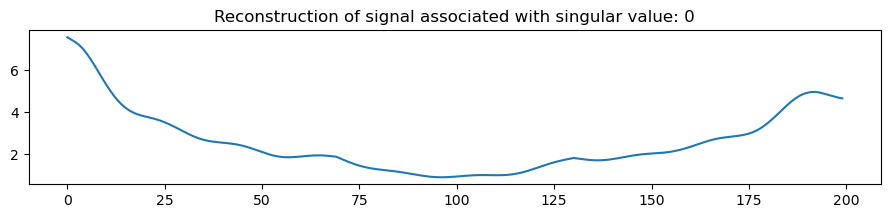

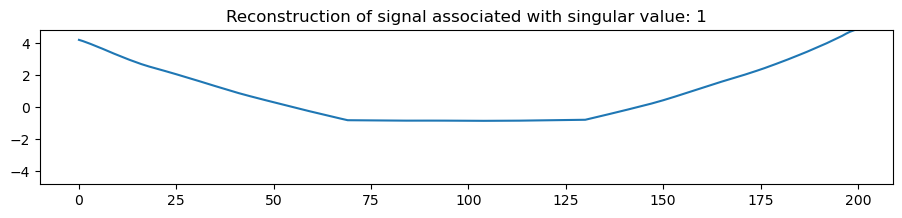

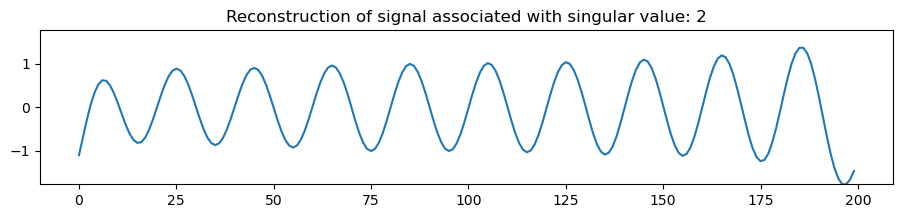

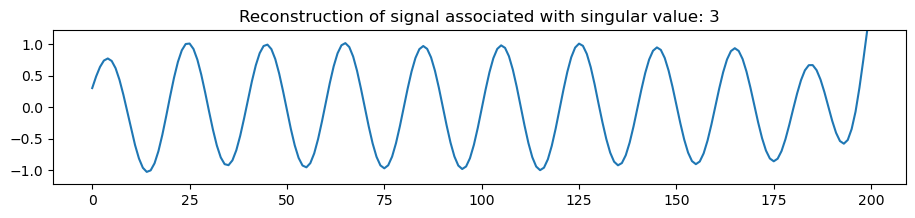

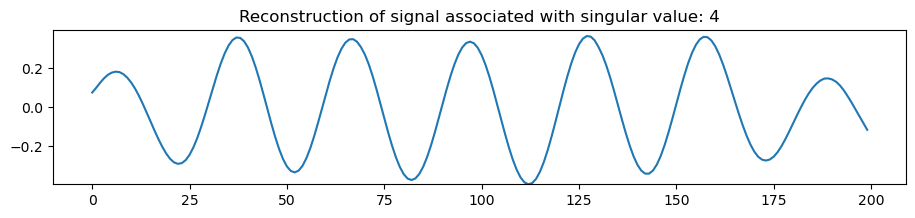

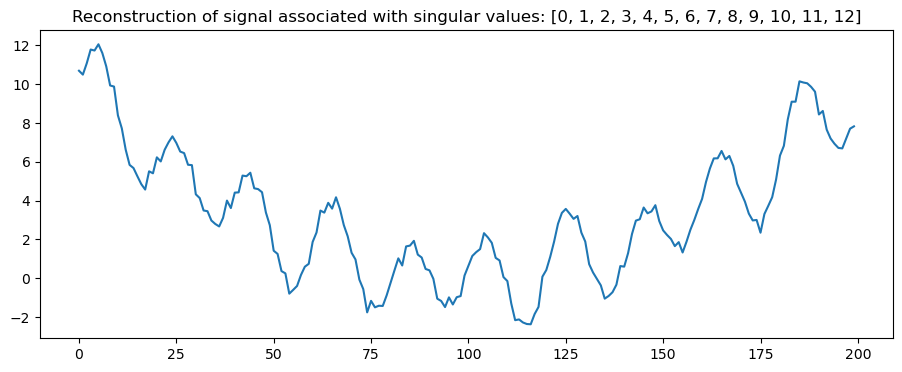

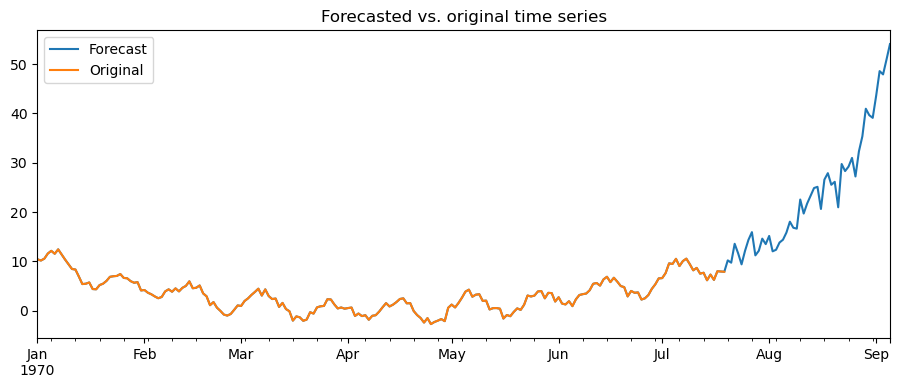

In [15]:
from pandas import DataFrame as df
import pandas as pd
import numpy as np
from matplotlib.pylab import rcParams

# Construct the data with gaps
ts_ = F.copy()
ssa = mySSA(ts_)

# Plot original series for reference
ssa.view_time_series()

ssa.embed(embedding_dimension=70, suspected_frequency=None, verbose=True)
ssa.decompose(True)
ssa.view_s_contributions(adjust_scale=True)



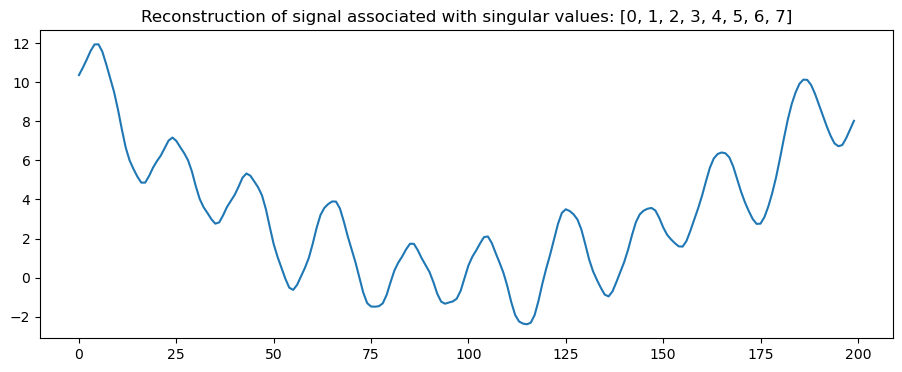

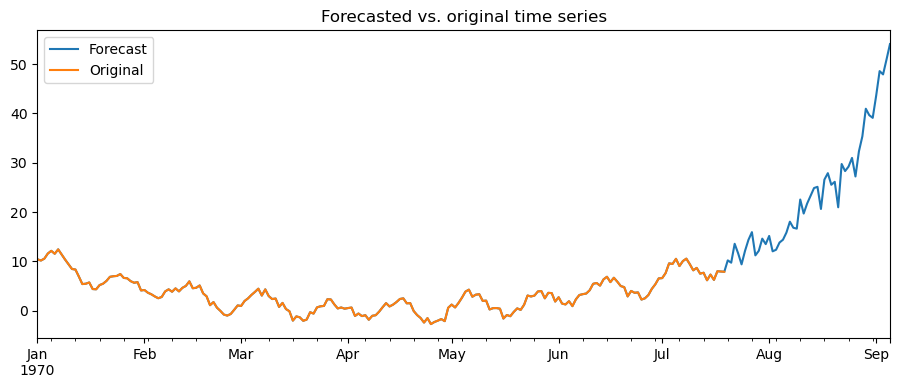

In [23]:
# Component Signals
components = [i for i in range(8)]
# RECONSTRUCTION
ssa.view_reconstruction(*[ssa.Xs[i] for i in components], names=components)

# FORECASTING
forecast_df = ssa.forecast_recurrent(steps_ahead=48, plot=True, return_df=True)

<AxesSubplot: >

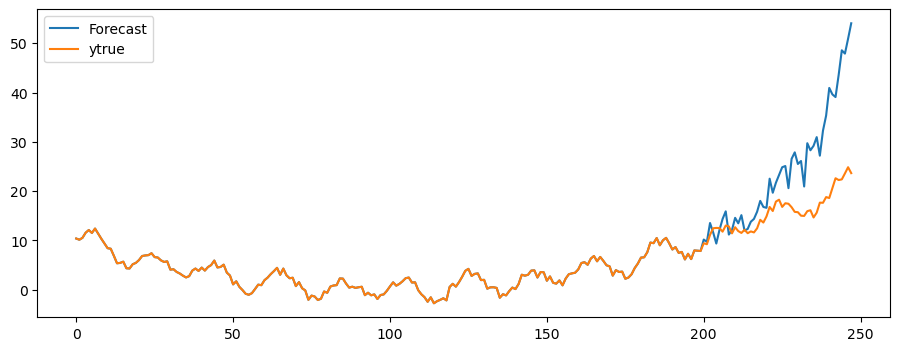

In [25]:
forecast_df["ytrue"] = Fo[0:forecast_df.shape[0]]
forecast_df[["Forecast", "ytrue"]].reset_index(drop=True).plot()

In [62]:
self.orthonormal_base[0].shape

(70, 1)

In [10]:
X_hat = np.zeros(X.shape)
R = np.zeros(orthonormal_base[0].shape)[0:-1]
verticality_coefficient = 0

for Pi in orthonormal_base.values():
    X_hat += np.matmul(Pi*Pi.T, X)
    pi = Pi[-1].item()
    verticality_coefficient += pi**2
    R += pi*Pi[:-1]

R /= (1-verticality_coefficient)


NameError: name 'orthonormal_base' is not defined

In [11]:
def calculate_R(orthonormal_base):
    R = np.zeros(orthonormal_base[0].shape)[0:-1]
    verticality_coefficient = 0
    for Pi in orthonormal_base.values():
        pi = Pi[-1].item()
        verticality_coefficient += pi**2
        R += pi*Pi[:-1]
    R /= (1-verticality_coefficient)
    return R

def forecast_ahead(F, orthonormal_base, L):
    R = calculate_R(orthonormal_base)
    N_ahead = 100
    F_pred = F.copy()
    for n in range(N_ahead):
        next_val = 0
        for i in range(len(R)):
            next_val += R[i]*F_pred[-L+1+i]
        F_pred = np.append(F_pred, next_val)
    return F_pred



In [12]:
num_components = 7
orthonormal_base = {i:U[:, i].reshape(-1, 1) for i in range(num_components)}
L = 70
F_pred = forecast_ahead(F, orthonormal_base, L)

In [13]:
def forecast_ahead(F, num_components, L, N_ahead = 100):
    X = build_trajectory_matrix(F, L)
    U, S, V = np.linalg.svd(X, full_matrices=False)
    orthonormal_base = {i:U[:, i].reshape(-1, 1) for i in range(num_components)}
    R = calculate_R(orthonormal_base)
    F_pred = F.copy()
    for n in range(N_ahead):
        next_val = 0
        for i in range(len(R)):
            next_val += R[i]*F_pred[-L+1+i]
        F_pred = np.append(F_pred, next_val)
    return F_pred

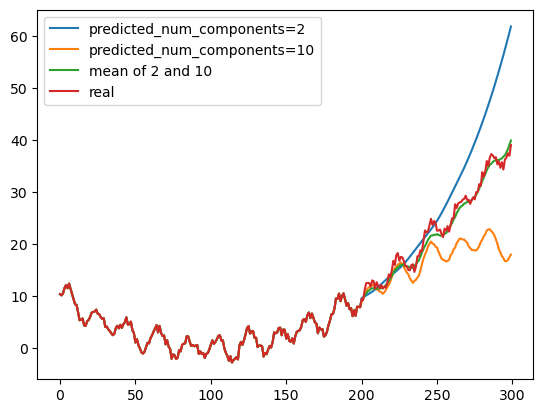

In [14]:
N_ahead = 100
F_pred2 = forecast_ahead(F, num_components=2, L=70, N_ahead = 100)
F_pred10 = forecast_ahead(F, num_components=10, L=70, N_ahead = 100)
# plot the real and predicted values
plt.plot(F_pred2[: 200+N_ahead], label='predicted_num_components=2')
plt.plot(F_pred10[: 200+N_ahead], label='predicted_num_components=10')
# mean of 2 and 10
plt.plot((F_pred2+F_pred10)/2, label='mean of 2 and 10')
plt.plot(Fo[: 200+N_ahead], label='real')
plt.legend()

In [89]:
# 
Fo[199:210]

array([ 7.8691161 ,  9.4357528 ,  9.23929049, 11.14040883, 12.47331522,
       12.54361532, 12.52302917, 11.78602493, 13.0258632 , 12.85685376,
       11.44129448])

In [90]:
F_pred[199:210]

array([ 7.8691161 ,  8.80212171,  9.5305857 , 10.25699395, 10.91874992,
       11.44461977])

In [ ]:
# Component Signals
components = [i for i in range(13)]
rcParams['figure.figsize'] = 11, 2
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

# RECONSTRUCTION
ssa.view_reconstruction(*[ssa.Xs[i] for i in components], names=components)

# FORECASTING
forecast_df = ssa.forecast_recurrent(steps_ahead=48, plot=True, return_df=True)

In [47]:
orthonormal_base = {}


NameError: name 'Pi' is not defined